In [1]:
import pyreadr, pickle, csv, re, os, tqdm
import numpy as np
import pandas as pd


import torch
import torch.nn as nn

from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

# Data Loading

In [2]:
N = 300 # How many genes to extract

path = '/home/sam/scRNAseq/Xenium/Network_genes_Normalized.RData'
rdata = pyreadr.read_r(path) # WS


In [3]:
# Load data
df = rdata['Retina_expMatrix_candidateGenes']
df['Cluster'] = df['Cluster'].apply(lambda x: x if len(x.split('_')[0]) == 2 else '0' + x) # Standardize cluster names

# Load the list of indices for each network to use
class_net_genes = rdata['Class_indices'].to_numpy().ravel()
rgc_net_genes = rdata['RGC_indices'].to_numpy().ravel()
ac_net_genes = rdata['AC_indices'].to_numpy().ravel()
bc_net_genes = rdata['BC_indices'].to_numpy().ravel()

In [4]:

df['cluster'] = df['Cluster']

def encode_class(arr):
    '''This function will encode subtypes' cell classesbased on expert rules and is not intended for decoding'''
    custom_array = []

    for value in arr:
        if re.match(r'^\d{2}_', value):
            custom_array.append(0)
        elif value.startswith('AC_'):
            custom_array.append(1)
        elif value.endswith('Photoreceptors'):
            custom_array.append(2)
        elif value == '0MG (Mueller Glia)':
            custom_array.append(3)
        elif value.startswith('0BC'):
            custom_array.append(4)
        elif value.startswith('0RBC'):
            # Note this duplication is for simplicity of handling the 2 BC naming conventions
            custom_array.append(4)
        else:
            custom_array.append(5)
    return custom_array

# Function to generate a sort key for each subclass name
def sort_key(name):
    if name.startswith('0BC'):
        return 4
    elif name.startswith('0RBC'):
        return 4
    elif re.match(r'^\d{2}_', name):
        return 0
    elif name.startswith('AC_'):
        return 1
    elif name.endswith('Photoreceptors'):
        return 2
    elif name == '0MG (Mueller Glia)':
        return 3
    
    else:
        return 5

# Apply the sort_key function to each subclass name and sort the DataFrame
df['sort_key'] = df['Cluster'].apply(sort_key)
df.sort_values(by='sort_key', inplace=True)
df.drop(columns='sort_key', inplace=True)  # Optionally remove the sort key

class_arr = encode_class(df['Cluster'])

# Encode the categoric response 
le = LabelEncoder()
df['Cluster'] = le.fit_transform(df['Cluster'])

# Move the response to the end for simply manipulation
cluster_col = df.pop('Cluster')
dataset_col = df.pop('Dataset')
df.insert(len(df.columns), 'Cluster', cluster_col)
df.insert(len(df.columns), 'Class', class_arr)

display(df)

,Kcnip4,Isl2,Glra1,Zic1,Syndig1l,Isl1,Pou3f1,Mmp9,Grm5,Cpne4,...,Glrb,Rbpms,Vamp1,Cspg4,Kcnq1ot1,Cdh5,Foxp1,cluster,Cluster,Class
rownames,,,,,,,,,,,,,,,,,,,,,
aRGC10_TTTGTCATCGCCTGAG.1,0.581697,0.92563,0.000000,0.0,0.000000,0.518247,0.0,1.347651,0.000000,0.870727,...,0.000000,1.224622,0.747942,0.0,0.000000,0.0,2.153310,04_FminiOFF,3,0
aRGC4_ACCGTAATCATTTGGG.1,0.417933,0.00000,0.000000,0.0,0.949320,0.000000,0.0,0.000000,0.917796,0.000000,...,0.496589,0.361727,0.502913,0.0,0.880912,0.0,0.000000,37_Novel,53,0
aRGC4_ACCGTAATCCTCTAGC.1,0.000000,0.00000,0.000000,0.0,0.501770,0.620176,0.0,0.000000,0.000000,0.697105,...,0.419215,0.643775,0.695561,0.0,0.782477,0.0,0.000000,08_Novel,7,0
aRGC4_ACCGTAATCGGCATCG.1,0.700281,0.00000,0.871270,0.0,0.474085,0.000000,0.0,0.000000,1.209090,0.000000,...,0.846013,0.616255,1.345877,0.0,1.000123,0.0,0.556282,26_Novel,42,0
aRGC4_ACCGTAATCTCCAACC.1,0.000000,0.00000,0.000000,0.0,1.048800,0.000000,0.0,0.000000,0.000000,0.000000,...,0.680279,0.925154,0.688942,0.0,1.027932,0.0,0.000000,12_ooDS_NT,28,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Bipolar5_ATACACTCACGA,0.000000,0.00000,1.043696,0.0,0.000000,0.000000,0.0,0.000000,0.876917,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0BC6,19,4
Bipolar5_ATGCTTTAGATG,0.000000,0.00000,0.000000,0.0,0.000000,1.047718,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0RBC (Rod Bipolar cell),24,4
Bipolar5_AGCACACCCCCT,0.000000,0.00000,0.000000,0.0,0.000000,0.464995,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0BC5A (Cone Bipolar cell 5A),15,4


In [5]:
def create_mapping(df):
    # Extract the unique pairs of encoded cluster values and their corresponding class encodings
    unique_pairs = df[['Cluster', 'Class']].drop_duplicates()
    
    # Create a dictionary mapping from Cluster to Class
    mapping = dict(zip(unique_pairs['Cluster'], unique_pairs['Class']))
    
    return mapping

# Usage
mapping = create_mapping(df)

print(mapping)


{3: 0, 53: 0, 7: 0, 42: 0, 28: 0, 35: 0, 0: 0, 45: 0, 33: 0, 30: 0, 2: 0, 26: 0, 41: 0, 1: 0, 32: 0, 6: 0, 48: 0, 5: 0, 59: 0, 38: 0, 54: 0, 4: 0, 27: 0, 49: 0, 51: 0, 34: 0, 31: 0, 44: 0, 39: 0, 36: 0, 40: 0, 50: 0, 55: 0, 56: 0, 47: 0, 43: 0, 8: 0, 29: 0, 37: 0, 52: 0, 61: 0, 46: 0, 57: 0, 58: 0, 60: 0, 122: 1, 62: 1, 96: 1, 84: 1, 106: 1, 123: 1, 63: 1, 72: 1, 66: 1, 95: 1, 68: 1, 85: 1, 73: 1, 79: 1, 71: 1, 90: 1, 89: 1, 117: 1, 70: 1, 91: 1, 98: 1, 92: 1, 64: 1, 104: 1, 82: 1, 65: 1, 78: 1, 76: 1, 87: 1, 74: 1, 88: 1, 109: 1, 83: 1, 101: 1, 67: 1, 124: 1, 75: 1, 99: 1, 86: 1, 81: 1, 77: 1, 80: 1, 97: 1, 120: 1, 93: 1, 112: 1, 116: 1, 100: 1, 114: 1, 107: 1, 94: 1, 111: 1, 69: 1, 105: 1, 102: 1, 118: 1, 110: 1, 108: 1, 103: 1, 115: 1, 113: 1, 119: 1, 121: 1, 22: 2, 25: 2, 23: 3, 15: 4, 24: 4, 20: 4, 19: 4, 9: 4, 12: 4, 13: 4, 11: 4, 17: 4, 21: 4, 10: 4, 18: 4, 14: 4, 16: 4}


In [6]:
# Utilize the mapping to count the number of subclasses for each class
subclass_counts = {i: 0 for i in range(6)}  # Initialize counts for 6 classes
for _, class_id in mapping.items():
    subclass_counts[class_id] += 1

# Construct the class_info dictionary
class_info = {
    'Genes': class_net_genes,  # Genes used for class classification
    'num_classes': 6,  # Total number of classes
    0: {  # Information for class 0 (RGCs)
        'Genes': rgc_net_genes,
        'num_subclasses': subclass_counts[0]
    },
    1: {  # Information for class 1 (ACs)
        'Genes': ac_net_genes,
        'num_subclasses': subclass_counts[1]
    },
    2: {  # Information for class 2
        'Genes': bc_net_genes,
        'num_subclasses': subclass_counts[2]
    },
    3: {  # Information for class 3
        'Genes': bc_net_genes,
        'num_subclasses': subclass_counts[3]
    },
    4: {  # Information for class 4
        'Genes': bc_net_genes,
        'num_subclasses': subclass_counts[4]
    },
    5: {  # Information for class 5 (Catch-all class)
        'Genes': class_net_genes,
        'num_subclasses': 1  # Only 1 subclass as it's a catch-all class
    }
}

In [7]:
# Shuffle the data
df = shuffle(df, random_state=42)

# Split the data into input features and labels
X = df.iloc[:, :-3].values.astype(np.float32)
X = np.round(X*100)/100
y = df.iloc[:, -2].values.astype(np.compat.long)

# Convert data to PyTorch tensors
X = torch.from_numpy(X)
y = torch.from_numpy(y)

# Split the data into training and test sets
train_size = int(0.8 * len(df))
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

# Networks and Utilities

In [8]:
class Net(nn.Module):
    def __init__(self, input_size, num_classes, h1_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, h1_size)
        self.fc2 = nn.Linear(h1_size, num_classes)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)
    

class TentacleNet(nn.Module):
    def __init__(self, input_size, num_subclasses):
        super(TentacleNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 2*num_subclasses)
        self.fc2 = nn.Linear(2*num_subclasses, num_subclasses)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return nn.functional.log_softmax(x, dim=1)

class CuttleNet(nn.Module):
    def __init__(self, class_info, mapping):
        super(CuttleNet, self).__init__()
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.n = len(mapping) # Number of subclasses
        self.class_info = class_info

        # Class Classifier
        self.class_fc1 = nn.Linear(len(class_info['Genes']), 2*class_info['num_classes'])
        self.class_fc2 = nn.Linear(2*class_info['num_classes'], class_info['num_classes'])

        # Subclass Classifiers
        self.subclass_nets = nn.ModuleDict({
            str(class_id): TentacleNet(input_size=len(subclass_info['Genes']) + class_info['num_classes'], 
                                       num_subclasses=subclass_info['num_subclasses'])
            for class_id, subclass_info in class_info.items()
            if isinstance(class_id, int)
        })
        
        # Calculate the number of subclasses for each class
        self.num_subclasses_per_class = self.calculate_subclasses_per_class(mapping)
        
    def get_subclass_range_for_class(self, class_id):
        start_index = sum(self.num_subclasses_per_class[cid] for cid in range(class_id))
        end_index = start_index + self.num_subclasses_per_class[class_id]
        return slice(start_index, end_index)
    
    def calculate_subclasses_per_class(self, mapping):
        """
        Calculate the number of subclasses for each class using the mapping.
        """
        num_subclasses_per_class = {class_id: 0 for class_id in range(self.class_info['num_classes'])}
        for subclass_id in mapping.keys():
            class_id = mapping[subclass_id]
            num_subclasses_per_class[class_id] += 1
        return num_subclasses_per_class

    def forward(self, x):
        # Class classification
        class_genes = x[:, self.class_info['Genes']]
        class_x = nn.functional.relu(self.class_fc1(class_genes))
        class_output = nn.functional.log_softmax(self.class_fc2(class_x), dim=1)

        # Initialize an output tensor for all subclasses
        all_subclass_output = torch.zeros(x.size(0), 130, device=self.device)  # Assuming 130 total subclasses

        # Populate the output tensor
        for class_id, subclass_info in self.class_info.items():
            if isinstance(class_id, int):
                subclass_genes = x[:, subclass_info['Genes']]
                subclass_input = torch.cat((subclass_genes, class_output), dim=1)

                # Convert class_id to string
                class_id_str = str(class_id)
                subclass_output = self.subclass_nets[class_id_str](subclass_input)

                # Get the range for this class's subclasses
                subclass_range = self.get_subclass_range_for_class(class_id)

                # Multiply subclass predictions by the class prediction probability
                all_subclass_output[:, subclass_range] = subclass_output * class_output[:, class_id].unsqueeze(1)

        return all_subclass_output


In [9]:
# This cell is an experiment in training currciulumn
# The idea is to specifically train networks to learn one class only
# To do this we will train it head on against one other class ata a time
# When trainign is complete the network will have been exposed to the desired class at least 44 times
# It will see all non-desired classes at least once
# In this instantiation the network will not be weighted ahead of time to know what class is the desired class
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

# Step 1: Prepare training data
def head2head(train_y, train_X, desired, noise):
    '''This function will take a desired category and a noise category and create a paired down dataset
    The paired down data set will be an equal mix of desired and noise
    If there are not enough noise examples, a random set will be duplicated to make the lengths match
    If there are too many noise samples, a random set will be excluded'''

    # Isolate the desired instances
    TS_desired_y = train_y[train_y == desired]
    TS_desired_X = train_X[train_y == desired]
    TS_noise_y = train_y[train_y == noise]
    TS_noise_X = train_X[train_y == noise]
    # Check if the desired class is longer, if so balance it with replicates from te noise
    if len(TS_desired_y) > len(TS_noise_y):
        delta = len(TS_desired_y) - len(TS_noise_y)
        indice = np.random.choice( range(len(TS_noise_y)), delta)
        indice = torch.tensor(indice)
        extra_y = TS_noise_y[indice]
        extra_X = TS_noise_X[indice]
        TS_noise_y = torch.cat((TS_noise_y,extra_y))
        TS_noise_X = torch.cat((TS_noise_X,extra_X))
    # Check if the desired class is shorter, if so randomely discard examples from the other
    elif len(TS_desired_y) < len(TS_noise_y):
        indice = np.random.choice( range(len(TS_noise_y)), len(TS_desired_y))
        indice = torch.tensor(indice)
        TS_noise_y = TS_noise_y[indice]
        TS_noise_X = TS_noise_X[indice]
    # Combine the two balanced data sets
    TS_y = torch.cat((TS_noise_y,TS_desired_y))
    TS_X = torch.cat((TS_noise_X,TS_desired_X))
    # Shuffle the data
    indice = np.random.choice( range(len(TS_y)), len(TS_y))
    indice = torch.tensor(indice)
    TS_y = TS_y[indice]
    TS_X = TS_X[indice]
    return TS_y, TS_X


def DesiredGeneCurriculum(train_y, train_X, desired=1):
    if desired!=None:
        # Create a training set using this function to create my desired class biased training set
        noise_inds = [i for i in np.unique(train_y) if i != desired]

    # Move the data to the GPU
    # Set the device to use (GPU if available, otherwise CPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Convert the input data to the appropriate data type for the GPU
    train_X = train_X.to(device)
    train_y = train_y.to(device)

    ts_datasets = []
    if desired!=None:
        for noise_ind in noise_inds:
            TS_y, TS_X = head2head(train_y, train_X, desired=desired, noise=noise_ind)
            ts_datasets.append(torch.utils.data.TensorDataset(TS_X, TS_y))
    else:
        ts_datasets.append(torch.utils.data.TensorDataset(train_X, train_y))

    # Concatenate all datasets into one training set
    training_set = torch.utils.data.ConcatDataset(ts_datasets)
    
    return training_set


class CustomLoss(nn.Module):
    def __init__(self, mapping, target_subtype, class_weight):
        super(CustomLoss, self).__init__()
        self.target_subtype = target_subtype
        self.cross_entropy_loss = nn.CrossEntropyLoss()
        self.class_weight = class_weight
        self.subtype_weight = 1-class_weight
        self.encoding_map = mapping
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    def probability_mapping(self, probabilities):
        # Create an empty tensor for intermediate probabilities
        intermediate_prob = torch.zeros(probabilities.shape[0], len(set(self.encoding_map.values())), device=self.device)

        # Create a tensor for the mapping indices
        mapping_indices = torch.tensor(list(self.encoding_map.values()), device=self.device)

        # Vectorized operation to sum probabilities for each intermediate class
        for i in range(len(set(self.encoding_map.values()))):
            intermediate_prob[:, i] = probabilities[:, mapping_indices == i].sum(dim=1)

        return intermediate_prob

    def forward(self, outputs, targets, delta = 0):
        # This delta catch ensures simple math errors during training from resulting in unreasonable delta values
        if delta < 0:
            delta = 0
        elif delta > 1:
            delta = 1
        if self.target_subtype == None:
            filtered_outputs = outputs
            filtered_targets = targets
        else:
            # Filter outputs and targets to keep only the values corresponding to the target_subtype
            filtered_outputs = torch.zeros_like(outputs)
            filtered_outputs[:, self.target_subtype] = outputs[:, self.target_subtype]

            filtered_targets = torch.where(targets == self.target_subtype, targets, torch.tensor(0, dtype=targets.dtype))

        # Convert filtered targets to class encodings using the mapping
        y_true_classes = torch.tensor([self.encoding_map[int(t)] for t in filtered_targets], device=self.device)
        
        if self.class_weight > 0:
            # Convert logits to probabilities
            probabilities = torch.exp(filtered_outputs)  # Since log_softmax was used in the model

            # Map to intermediate probabilities
            y_pred_classes = self.probability_mapping(probabilities)

            # Convert probabilities to log probabilities for NLLLoss
            log_probabilities = torch.log(y_pred_classes + 1e-6)  # Adding a small value for numerical stability

            # Calculate the CrossEntropyLoss using the filtered outputs and targets for subtypes
            loss_sc = self.cross_entropy_loss(filtered_outputs, filtered_targets)

            # Calculate NLLLoss using log probabilities and true classes
            nll_loss = nn.NLLLoss()
            loss_c = nll_loss(log_probabilities, y_true_classes)

            # Weight the losses based on current stage of training or experiment
            loss = loss_sc*(self.subtype_weight+delta) + loss_c*(self.class_weight-delta)

            return loss
        else:
            # Calculate the CrossEntropyLoss using the filtered outputs and targets for subtypes
            return self.cross_entropy_loss(filtered_outputs, filtered_targets)
        

def QuickNN(training_set, class_info, n, num_epochs, batch_size, mapping,
            target_subtype=None, class_weight=1, deltaRate = 0, Cuttle = True, NetMult=2,
            l1_lambda = 0.0, stopEarly = 10, visualize=False, returnLoss=False):
    # Set the device to use (GPU if available, otherwise CPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Step 2: Define neural network
    # Instantiate the neural network model
    inputs = training_set[0][0].shape[0]
    if Cuttle:
        model = CuttleNet(class_info, mapping).to(device)
    else:
        model = Net(input_size=inputs, num_classes=n, h1_size=n*NetMult).to(device)

    # Define the loss function and optimizer
    criterion = CustomLoss(mapping, target_subtype, class_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=l1_lambda, amsgrad=True)

    # Define the learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
                                                          factor=0.05, patience=5)
    
    # Step 3: Set up training loop
    train_loader = DataLoader(training_set, batch_size=batch_size, shuffle=True)
    best_loss = float('inf')  # initialize the best validation loss
    early_stop_counter = 0  # initialize the early stopping counter

    if stopEarly > 0:
        print("Early Stopping Initialized")
        # Create the validation set
        val_size = int(len(training_set) * 0.2) # Use 20% of the training set for validation
        val_set, train_set = random_split(training_set, [val_size, len(training_set) - val_size])
        val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

    train_losses = []
    val_losses = []
    delta = 0
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            if len(inputs) == 0:
                continue
            inputs, targets = inputs.to(device), targets.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, targets, delta = delta)
            epoch_loss += loss.item()

            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_losses.append(epoch_loss / len(train_loader))

            
        # Increment delta at the end of each epoch
        if deltaRate > 0:
            delta += deltaRate
            delta = min(delta, 1)  # Ensure delta does not exceed 1
            print(f'\rEpoch {epoch+1}/{num_epochs}, Current Delta: {delta:.3f}', end='')

        if stopEarly > 0:
            
            # Evaluate the model on the validation set
            with torch.no_grad():
                val_loss = 0.0
                for inputs, targets in val_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    val_loss += criterion(outputs, targets).item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            # Check if the validation loss has improved
            if np.round(val_loss,5) < best_loss:
                best_loss = val_loss
                early_stop_counter = 0
            else:
                early_stop_counter += 1
                if early_stop_counter >= stopEarly:  # if the validation loss hasn't improved for 10 epochs, stop training
                    print(f"Early stopping at: Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
                    break
        else:
            # Update the learning rate using the scheduler
            lr_scheduler.step(loss)


        if visualize:
            # Print the training loss and learning rate after every epoch
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}, Learning rate: {optimizer.param_groups[0]['lr']:.6f}")
    if returnLoss:
        return model, (train_losses, val_losses)
    else:
        return model

def TestModel(test_X, test_y, model, le, visualize=True):
    # Set the device to use (GPU if available, otherwise CPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_X = test_X.to(device)
    test_y = test_y.to(device)

    # Evaluate the model on the test set
    with torch.no_grad():
        outputs = model(test_X)
        _, predicted = torch.max(outputs.data, 1)

    results = pd.DataFrame()
    for i in range(min(y), max(y)+1):
        cells = sum(test_y==i).item()
        test_y_i = test_y==i
        y_pred_i = predicted==i
        TP = sum((test_y_i==1) & (y_pred_i==1)).item()
        FP = sum((test_y_i==0) & (y_pred_i==1)).item()
        TN = sum((test_y_i==0) & (y_pred_i==0)).item()
        FN = sum((test_y_i==1) & (y_pred_i==0)).item()
        TPR = TP / np.where(TP+FN == 0, np.nan, TP+FN)
        TNR = TN / np.where(TN+FP == 0, np.nan, TN+FP)
        Prec = TP / np.where(TP+FP == 0, np.nan, TP+FP)
        F1 = 2 * (Prec * TPR) / np.where((Prec + TPR) == 0, np.nan, Prec + TPR)
        Accuracy = (TP+TN) / np.where(TP+FP+FN+TN == 0, np.nan, TP+FP+FN+TN)

        res_i = {'Cluster' : le.inverse_transform([i])[0],
            'cells' : cells,
            'TP' : TP,
            'FP' : FP,
            'TN' : TN,
            'FN' : FN,
            'TPR' : TPR,
            'TNR' : TNR,
            'Prec' : Prec,
            'F1' : F1,
            'Accuracy' : Accuracy}
        
        res_i = pd.DataFrame([res_i])
        results = pd.concat([results,res_i], ignore_index=True)
        
    if visualize:
        display(results.sort_values(by=['Cluster']))

    return results

def class_decoder(class_index):
    if class_index == 0:
        return 'RGC'  # or the appropriate class name
    elif class_index == 1:
        return 'AC'  # replace with the actual class name
    elif class_index == 2:
        return 'Ph'  # adjust as necessary
    elif class_index == 3:
        return 'MG'  # or the correct class name
    elif class_index == 4:
        return 'BC' 
    # Add additional cases as needed
    else:
        return 'Other'

def TestModelClass(test_X, test_y, model, le, mapping, visualize=True):
    # Set the device to use (GPU if available, otherwise CPU)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    test_X = test_X.to(device)
    test_y = test_y.to(device)
    
    # Transform test_y from subclass labels to class labels
    test_y = torch.tensor([mapping[subclass_label.item()] for subclass_label in test_y], device=device)

    # Evaluate the model on the test set
    with torch.no_grad():
        outputs = model(test_X)
        # Convert logits to probabilities
        probabilities = torch.exp(outputs)
        # Initialize tensor for aggregated class probabilities
        class_probs = torch.zeros(probabilities.shape[0], len(set(mapping.values())), device=device)

        # Aggregate probabilities for each class
        for subclass, class_ in mapping.items():
            class_probs[:, class_] += probabilities[:, subclass]

    # Determine class predictions
    _, class_predictions = torch.max(class_probs, 1)
    
    results = pd.DataFrame()
    for i in range(0, 6):
        cells = sum(test_y==i).item()
        test_y_i = test_y==i
        y_pred_i = class_predictions==i
        TP = sum((test_y_i==1) & (y_pred_i==1)).item()
        FP = sum((test_y_i==0) & (y_pred_i==1)).item()
        TN = sum((test_y_i==0) & (y_pred_i==0)).item()
        FN = sum((test_y_i==1) & (y_pred_i==0)).item()
        TPR = TP / np.where(TP+FN == 0, np.nan, TP+FN)
        TNR = TN / np.where(TN+FP == 0, np.nan, TN+FP)
        Prec = TP / np.where(TP+FP == 0, np.nan, TP+FP)
        F1 = 2 * (Prec * TPR) / np.where((Prec + TPR) == 0, np.nan, Prec + TPR)
        Accuracy = (TP+TN) / np.where(TP+FP+FN+TN == 0, np.nan, TP+FP+FN+TN)

        res_i = {'Class' : class_decoder(i),
            'cells' : cells,
            'TP' : TP,
            'FP' : FP,
            'TN' : TN,
            'FN' : FN,
            'TPR' : TPR,
            'TNR' : TNR,
            'Prec' : Prec,
            'F1' : F1,
            'Accuracy' : Accuracy}
        
        res_i = pd.DataFrame([res_i])
        results = pd.concat([results,res_i], ignore_index=True)
        
    if visualize:
        display(results.sort_values(by=['Class']))
    return(results)

def PickleSalad(save_dir):
        # Initialize a dictionary to store all experiment results
    all_experiment_results = {}

    # Loop through each file in the directory
    for filename in os.listdir(save_dir):
        if filename.startswith("experiment_results_") and filename.endswith(".pkl"):
            file_path = os.path.join(save_dir, filename)
            # Load the experiment result
            with open(file_path, 'rb') as f:
                experiment_data = pickle.load(f)
            # Use filename as a unique key
            experiment_key = filename.replace('.pkl', '')
            all_experiment_results[experiment_key] = experiment_data

    # Save the consolidated results to a pickle file
    all_results_pickle_path = os.path.join(save_dir, "all_results/all_experiment_results.pkl")
    os.makedirs(os.path.dirname(all_results_pickle_path), exist_ok=True)
    with open(all_results_pickle_path, 'wb') as f:
        pickle.dump(all_experiment_results, f)

    # Load the consolidated experiment results
    with open(all_results_pickle_path, 'rb') as f:
        consolidated_results = pickle.load(f)

    # Initialize empty DataFrames to store the filtered results
    class_results_df = pd.DataFrame()
    subtype_results_df = pd.DataFrame()

    # Loop through the consolidated experiment results
    for key, data in consolidated_results.items():
        # Process class-level results
        test_class_results = pd.DataFrame(data['class_results'])
        test_class_results['replicate'] = data['seed']
        for param_key, param_value in data['hyperparameters'].items():
            test_class_results[param_key] = param_value
        class_results_df = pd.concat([class_results_df, test_class_results], ignore_index=True)

        # Process subclass-level results
        test_subtype_results = pd.DataFrame(data['results'])
        test_subtype_results['replicate'] = data['seed']
        for param_key, param_value in data['hyperparameters'].items():
            test_subtype_results[param_key] = param_value
        subtype_results_df = pd.concat([subtype_results_df, test_subtype_results], ignore_index=True)

    # Save the filtered class-level results to a CSV file
    csv_file_path_class = os.path.join(save_dir, 'experiment_results_perClass.csv')
    class_results_df.to_csv(csv_file_path_class, index=False)

    # Save the filtered subclass-level results to a CSV file
    csv_file_path_subtype = os.path.join(save_dir, 'experiment_results_perSubtype.csv')
    subtype_results_df.to_csv(csv_file_path_subtype, index=False)

    print("Filtered experiment results saved successfully.")

# CuttleNet Grid Search

In [58]:
# Grid search over CuttleNet
# # Convert train_X and test_X to PyTorch tensors on the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_X = train_X.to(device)
test_X = test_X.to(device)


# Directory to save experimental data
save_dir = "/home/sam/scRNAseq/Xenium/ClassVsSubclass/Experiment4/"

# Check if the directory exists, if not create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

n = len(np.unique(y))
num_epochs = 100 # specify the number of epochs to train for
batch_size = 32 # specify the batch size for training
# Define hyperparameters to test
num_epochs_options = [10, 25, 50, 100]
early_stopping_options = [0, 5, 10]
l1_lambda_options = [0.0, 0.001, 0.005, 0.01]

# Initialize a dictionary to store results
experiment_results = {}

# Experiment loop
for seed in range(18,108,18):
    for epochs in num_epochs_options:
        for early_stop in early_stopping_options:
            for l1_lambda in l1_lambda_options:
                print(f'Testing seed: {seed}, with {epochs} epochs, early stopping at {early_stop} and regularization of {l1_lambda}')
                # Setting the seed for reproducibility
                torch.manual_seed(seed)
                np.random.seed(seed)
                
                experiment_id = f"epochs_{epochs}_earlyStop_{early_stop}_l1_{l1_lambda}_seed_{seed}"
                model_path = os.path.join(save_dir, f"model_state_{experiment_id}.pt")
                result_pickle_path = os.path.join(save_dir, f"experiment_results_{experiment_id}.pkl")

                # Check if the experiment has not been done
                if not os.path.exists(result_pickle_path):
                    print(f'Testing seed: {experiment_id}')

                    # Prepare the training dataset
                    training_set = DesiredGeneCurriculum(train_y, train_X, desired=None)

                    # Instantiate and train the model
                    model, loss_history = QuickNN(training_set, class_info=class_info, n=n, num_epochs=epochs, 
                                    batch_size=batch_size, mapping=mapping, class_weight=0,
                                    l1_lambda=l1_lambda, stopEarly=early_stop, visualize=False, returnLoss=True)
                    model = model.to(device)

                    # Evaluate the model on the test set
                    results = TestModel(test_X, test_y, model, le, visualize=False)
                    class_results = TestModelClass(test_X, test_y, model, le, mapping, visualize=False)

                    # Store the results
                    experiment_results[experiment_id] = {
                        'seed' : seed,
                        'model_path': model_path,
                        'results': results,
                        'class_results' : class_results,
                        'hyperparameters': {
                            'num_epochs': epochs,
                            'early_stopping': early_stop,
                            'l1_lambda': l1_lambda
                        },
                        'loss_history': loss_history
                    }

                    # Instead of storing the model in experiment_results, save it directly to a file
                    torch.save(model.state_dict(), model_path)

                    # Save the experiment results after each iteration
                    with open(result_pickle_path, 'wb') as f:
                        pickle.dump(experiment_results[experiment_id], f)

                    print(f"Completed: {experiment_id}")
                    # Free up memory after each iteration
                    torch.cuda.empty_cache()

PickleSalad(save_dir = save_dir)

Testing seed: 18, with 10 epochs, early stopping at 0 and regularization of 0.0
Testing seed: 18, with 10 epochs, early stopping at 0 and regularization of 0.001
Testing seed: 18, with 10 epochs, early stopping at 0 and regularization of 0.005
Testing seed: 18, with 10 epochs, early stopping at 0 and regularization of 0.01
Testing seed: 18, with 10 epochs, early stopping at 5 and regularization of 0.0
Testing seed: 18, with 10 epochs, early stopping at 5 and regularization of 0.001
Testing seed: 18, with 10 epochs, early stopping at 5 and regularization of 0.005
Testing seed: 18, with 10 epochs, early stopping at 5 and regularization of 0.01
Testing seed: 18, with 10 epochs, early stopping at 10 and regularization of 0.0
Testing seed: 18, with 10 epochs, early stopping at 10 and regularization of 0.001
Testing seed: 18, with 10 epochs, early stopping at 10 and regularization of 0.005
Testing seed: 18, with 10 epochs, early stopping at 10 and regularization of 0.01
Testing seed: 18, wit

AttributeError: Can't get attribute 'TwoPartNet' on <module '__main__'>

In [49]:
# # Use this to rebuild a specific model

# # Directory to save experimental data
# save_dir = "/home/sam/scRNAseq/Xenium/ClassVsSubclass/Experiment4/all_results/"

# # Check if the directory exists, if not create it
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)
    
# n = len(np.unique(y))
# batch_size = 32 # specify the batch size for training

# # Define hyperparameters to test
# epochs = 50
# early_stop = 10
# l1_lambda = 0.001
# seed = 18

# # Initialize a dictionary to store results
# experiment_results = {}

# # Experiment training
# print(f'Rebuilding seed: {seed}, with {epochs} epochs, early stopping at {early_stop} and regularization of {l1_lambda}')
# # Setting the seed for reproducibility
# torch.manual_seed(seed)
# np.random.seed(seed)

# # Prepare the training dataset
# training_set = DesiredGeneCurriculum(train_y, train_X, desired=None)

# # Instantiate and train the model
# model, loss_history = QuickNN(training_set, class_info=class_info, n=n, num_epochs=epochs, 
#                 batch_size=batch_size, mapping=mapping, class_weight=0,
#                 l1_lambda=l1_lambda, stopEarly=early_stop, visualize=True, returnLoss=True)

# model = model.to(device)

# # Evaluate the model on the test set
# results = TestModel(test_X, test_y, model, le, visualize=False)

# # Store the results
# experiment_id = f"Optimal Training epochs_{epochs}_earlyStop_{early_stop}_l1_{l1_lambda}"
# experiment_results[experiment_id] = {
#     'seed' : seed,
#     'model': model,
#     'results': results,
#     'hyperparameters': {
#         'num_epochs': epochs,
#         'early_stopping': early_stop,
#         'l1_lambda': l1_lambda
#     },
#     'loss_history': loss_history
# }

# # Save the experiment results after each iteration
# with open(os.path.join(save_dir, f"experiment_results_{experiment_id}.pkl"), 'wb') as f:
#     pickle.dump(experiment_results[experiment_id], f)

# print(f"Completed: {experiment_id}")

In [23]:
# # Set Pandas display options to show all rows
# pd.set_option('display.max_rows', None)

# display(results.sort_values(by='F1', ascending=False))

# # Reset the display option to default after displaying 
# pd.reset_option('display.max_rows')

,Cluster,cells,TP,FP,TN,FN,TPR,TNR,Prec,F1,Accuracy
23,0MG (Mueller Glia),558,558,0,18402,0,1.000000,1.000000,1.000000,1.000000,1.000000
22,0Cone Photoreceptors,12,12,0,18948,0,1.000000,1.000000,1.000000,1.000000,1.000000
25,0Rod Photoreceptors,18,18,0,18942,0,1.000000,1.000000,1.000000,1.000000,1.000000
24,0RBC (Rod Bipolar cell),2181,2174,28,16751,7,0.996790,0.998331,0.987284,0.992015,0.998154
33,17_Tbr1_S1,145,145,3,18812,0,1.000000,0.999841,0.979730,0.989761,0.999842
0,01_W3D1.1,641,634,10,18309,7,0.989080,0.999454,0.984472,0.986770,0.999103
26,10_Novel,245,242,6,18709,3,0.987755,0.999679,0.975806,0.981744,0.999525
92,AC_37,53,52,1,18906,1,0.981132,0.999947,0.981132,0.981132,0.999895
2,03_FminiON,397,385,5,18558,12,0.969773,0.999731,0.987179,0.978399,0.999103
3,04_FminiOFF,377,360,1,18582,17,0.954907,0.999946,0.997230,0.975610,0.999051


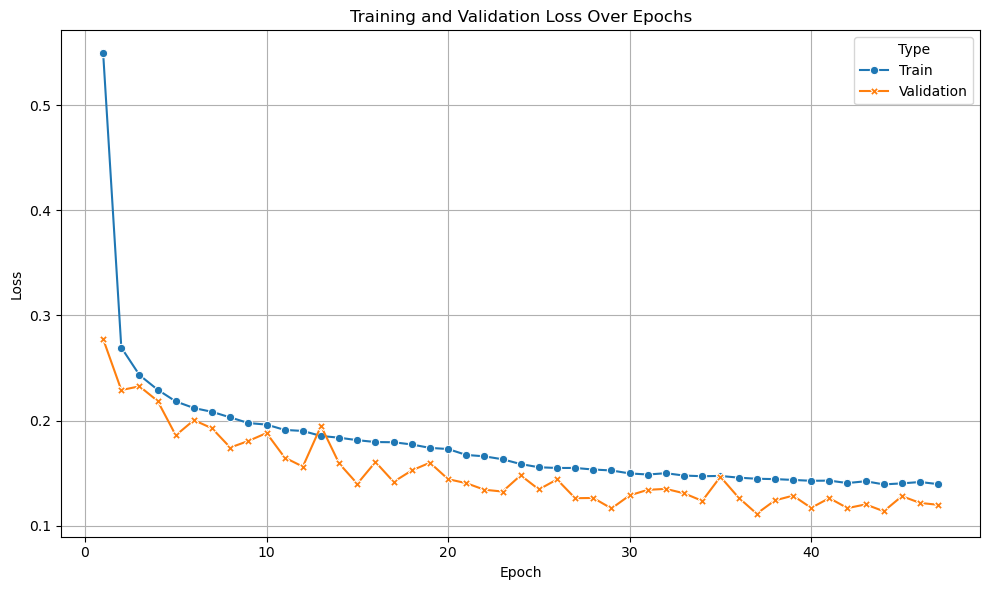

'/home/sam/scRNAseq/Xenium/ClassVsSubclass/Experiment4/loss_history_plot.png'

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming experiment_results contains the required data
# Extract loss history for a specific experiment
loss_history = experiment_results[experiment_id]['loss_history']
train_losses = loss_history[0]
val_losses = loss_history[1]

# Prepare data for plotting
epochs_range = range(1, len(train_losses) + 1)
plot_data = pd.DataFrame({
    'Epoch': list(epochs_range) + list(epochs_range),
    'Loss': train_losses + val_losses,
    'Type': ['Train']*len(train_losses) + ['Validation']*len(val_losses)
})

# Create the plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_data, x='Epoch', y='Loss', hue='Type', style='Type', markers=True, dashes=False)
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Type')
plt.grid(True)
plt.tight_layout()

# Save the plot
plot_save_path = os.path.join(results_dir, "loss_history_plot.png")
plt.savefig(plot_save_path)

# Show the plot
plt.show()

plot_save_path


# DeltaRate for CuttleNet

In [59]:
# Testing Optimal GLM DeltaRate on Optimal CuttleNet
# # Convert train_X and test_X to PyTorch tensors on the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_X = train_X.to(device)
test_X = test_X.to(device)


# Directory to save experimental data
save_dir = "/home/sam/scRNAseq/Xenium/ClassVsSubclass/Experiment6/"

# Check if the directory exists, if not create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

n = len(np.unique(y))
batch_size = 32 # specify the batch size for training
# Define hyperparameters to test
epochs = 25
early_stop = 0
l1_lambda = 0.001
dr = 0.75

# Initialize a dictionary to store results
experiment_results = {}

# Experiment loop
for seed in range(18,108,18):

    print(f'Testing seed: {seed}, with {epochs} epochs, early stopping at {early_stop} and regularization of {l1_lambda}, with deltaRate = {dr}')
    # Setting the seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    experiment_id = f"epochs_{epochs}_earlyStop_{early_stop}_l1_{l1_lambda}_deltaRate_{dr}_seed_{seed}"
    model_path = os.path.join(save_dir, f"model_state_{experiment_id}.pt")
    result_pickle_path = os.path.join(save_dir, f"experiment_results_{experiment_id}.pkl")
    
    # Check if the experiment has not been done
    if not os.path.exists(result_pickle_path):
        print(f'Testing seed: {experiment_id}')


        # Prepare the training dataset
        training_set = DesiredGeneCurriculum(train_y, train_X, desired=None)

        # Instantiate and train the model
        model, loss_history = QuickNN(training_set, class_info=class_info, n=n, num_epochs=epochs, 
                        batch_size=batch_size, mapping=mapping, class_weight=0, deltaRate=dr,
                        l1_lambda=l1_lambda, stopEarly=early_stop, visualize=False, returnLoss=True)
        model = model.to(device)

        # Evaluate the model on the test set
        results = TestModel(test_X, test_y, model, le, visualize=False)
        class_results = TestModelClass(test_X, test_y, model, le, mapping, visualize=False)

        # Store the results
        
        experiment_results[experiment_id] = {
            'seed' : seed,
            'model_path': model_path,
            'results': results,
            'class_results' : class_results,
            'hyperparameters': {
                'num_epochs': epochs,
                'early_stopping': early_stop,
                'l1_lambda': l1_lambda,
                'deltaRate':dr,
            },
            'loss_history': loss_history
        }

        # Instead of storing the model in experiment_results, save it directly to a file
        torch.save(model.state_dict(), model_path)

        # Save the experiment results after each iteration
        with open(result_pickle_path, 'wb') as f:
            pickle.dump(experiment_results[experiment_id], f)

        print(f"Completed: {experiment_id}")
        # Free up memory after each iteration
        torch.cuda.empty_cache()

PickleSalad(save_dir = save_dir)

Testing seed: 18, with 25 epochs, early stopping at 0 and regularization of 0.001, with deltaRate = 0.75
Testing seed: 36, with 25 epochs, early stopping at 0 and regularization of 0.001, with deltaRate = 0.75
Testing seed: 54, with 25 epochs, early stopping at 0 and regularization of 0.001, with deltaRate = 0.75
Testing seed: 72, with 25 epochs, early stopping at 0 and regularization of 0.001, with deltaRate = 0.75
Testing seed: 90, with 25 epochs, early stopping at 0 and regularization of 0.001, with deltaRate = 0.75
Filtered experiment results saved successfully.


# Ablation Studies

In [10]:
# Remove all genes with imputed 0s to see if the follwoing architectures were using them to cheat

# class_net_genes: variable with indices of genes that are not useful

# Shuffle the data
df = shuffle(df, random_state=42)

# Split the data into input features and labels
X = df.iloc[:, :-3].values.astype(np.float32)
X = np.round(X*100)/100

print(f'Original Number of Genes: {X.shape[1]}')
X_clean = X[:, class_net_genes] # Ablate genes by subsetting only those without imputed values
y = df.iloc[:, -2].values.astype(np.compat.long)

# Convert data to PyTorch tensors
X = torch.from_numpy(X_clean) # Overwrite X
y = torch.from_numpy(y)

print(f'Ablated Number of Genes: {X.shape[1]}')

# Split the data into training and test sets
train_size = int(0.8 * len(df))
train_X, test_X = X[:train_size], X[train_size:]
train_y, test_y = y[:train_size], y[train_size:]

Original Number of Genes: 300
Ablated Number of Genes: 242


In [11]:
# Testing GLM DeltaRate on Dataset without Imputed Genes
# # Convert train_X and test_X to PyTorch tensors on the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_X = train_X.to(device)
test_X = test_X.to(device)


# Directory to save experimental data
save_dir = "/home/sam/scRNAseq/Xenium/ClassVsSubclass/Experiment8/"

# Check if the directory exists, if not create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

n = len(np.unique(y))
batch_size = 32 # specify the batch size for training
# Define hyperparameters to test
epochs = 50
early_stop = 0
l1_lambda_options = [0, 0.001]
dr_options = [0, 0.75]
GLM_size_options = [2,3]

# Initialize a dictionary to store results
experiment_results = {}

# Experiment loop
for seed in range(18,108,18):
    for dr in dr_options:
        for l1_lambda in l1_lambda_options:
            for s in GLM_size_options:

                print(f'Testing Ablation seed: {seed}, with GLM size {s}, regularization of {l1_lambda}, with deltaRate = {dr}')
                # Setting the seed for reproducibility
                torch.manual_seed(seed)
                np.random.seed(seed)
                
                experiment_id = f"Ablation_GLMsize_{s}_l1_{l1_lambda}_deltaRate_{dr}_seed_{seed}"
                model_path = os.path.join(save_dir, f"model_state_{experiment_id}.pt")
                result_pickle_path = os.path.join(save_dir, f"experiment_results_{experiment_id}.pkl")

                # Check if the experiment has not been done
                if not os.path.exists(result_pickle_path):
                    print(f'Testing seed: {experiment_id}')

                    # Prepare the training dataset
                    training_set = DesiredGeneCurriculum(train_y, train_X, desired=None)

                    # Instantiate and train the model
                    model, loss_history = QuickNN(training_set, class_info=class_info, n=n, num_epochs=epochs, 
                                                  Cuttle=False, NetMult=s,
                                    batch_size=batch_size, mapping=mapping, class_weight=0, deltaRate=dr,
                                    l1_lambda=l1_lambda, stopEarly=early_stop, visualize=False, returnLoss=True)
                    model = model.to(device)

                    # Evaluate the model on the test set
                    results = TestModel(test_X, test_y, model, le, visualize=False)
                    class_results = TestModelClass(test_X, test_y, model, le, mapping, visualize=False)

                    # Store the results

                    experiment_results[experiment_id] = {
                        'seed' : seed,
                        'model_path': model_path,
                        'results': results,
                        'class_results' : class_results,
                        'hyperparameters': {
                            'num_epochs': epochs,
                            'early_stopping': early_stop,
                            'l1_lambda': l1_lambda,
                            'deltaRate':dr,
                            'Layer1' : n*s
                        },
                        'loss_history': loss_history
                    }

                    # Instead of storing the model in experiment_results, save it directly to a file
                    torch.save(model.state_dict(), model_path)

                    # Save the experiment results after each iteration
                    with open(result_pickle_path, 'wb') as f:
                        pickle.dump(experiment_results[experiment_id], f)

                    print(f"Completed: {experiment_id}")
                    # Free up memory after each iteration
                    torch.cuda.empty_cache()

                    # Optionally, save the entire dictionary at the end
                    with open(os.path.join(save_dir, "all_results/all_experiment_results.pkl"), 'wb') as f:
                        pickle.dump(experiment_results, f)

PickleSalad(save_dir = save_dir)

Testing Ablation seed: 18, with GLM size 2, regularization of 0, with deltaRate = 0
Testing seed: Ablation_GLMsize_2_l1_0_deltaRate_0_seed_18
Completed: Ablation_GLMsize_2_l1_0_deltaRate_0_seed_18
Testing Ablation seed: 18, with GLM size 3, regularization of 0, with deltaRate = 0
Testing seed: Ablation_GLMsize_3_l1_0_deltaRate_0_seed_18
Completed: Ablation_GLMsize_3_l1_0_deltaRate_0_seed_18
Testing Ablation seed: 18, with GLM size 2, regularization of 0.001, with deltaRate = 0
Testing seed: Ablation_GLMsize_2_l1_0.001_deltaRate_0_seed_18
Completed: Ablation_GLMsize_2_l1_0.001_deltaRate_0_seed_18
Testing Ablation seed: 18, with GLM size 3, regularization of 0.001, with deltaRate = 0
Testing seed: Ablation_GLMsize_3_l1_0.001_deltaRate_0_seed_18
Completed: Ablation_GLMsize_3_l1_0.001_deltaRate_0_seed_18
Testing Ablation seed: 18, with GLM size 2, regularization of 0, with deltaRate = 0.75
Testing seed: Ablation_GLMsize_2_l1_0_deltaRate_0.75_seed_18
Epoch 50/50, Current Delta: 1.000Complet

KeyboardInterrupt: 

In [14]:
experiment_results["Ablation_GLMsize_2_l1_0_deltaRate_0.75_seed_18"]['hyperparameters']["Layer1"]

250

# Xenium Inference

In [89]:
# Load xenium data
# path = '/home/sam/scRNAseq/Xenium/AlonNN/cell_puncta_matrix.csv'
path = '/home/sam/scRNAseq/Xenium/AlonNN/Eye1_Slide2_Region2_expression_matrix_normalized_dist5_GCL.csv'
xenium = pd.read_csv(path)

# Convert to torch
X_xen = xenium.iloc[:, 4:]#.apply(lambda x: x / x.max()) # Normalize puncta counts
X_xen = X_xen.values.astype(np.float32) # convert to float32 array
X_xen = np.round(X_xen*100)/100 # Round
X_xen = torch.from_numpy(X_xen) # Convert data to PyTorch tensors

print(X_xen)

tensor([[1.4000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.7700],
        [0.7500, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.1900, 0.0000, 1.0100,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.2900, 0.0000, 0.0000,  ..., 0.7000, 0.0000, 0.6200],
        [0.0000, 0.0000, 0.0000,  ..., 0.8200, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])


In [90]:
# Ensure that model is in evaluation mode
model.eval()

# Run inference
with torch.no_grad():  # This context manager tells PyTorch not to compute or store gradients
    X_xen = X_xen.to(device)
    
    # Forward pass through the model
    outputs = model(X_xen)


In [91]:
# Run inference and get predicted classes
predicted_classes = torch.argmax(outputs, dim=1)

# Decode the predictions to original labels
predicted_sc = le.inverse_transform(predicted_classes.cpu().numpy())
predicted_classes = encode_class(predicted_sc)

pred_df = pd.DataFrame({
    'subclass': predicted_sc,
    'class': predicted_classes
})


with open ('/home/sam/scRNAseq/Xenium/E1S2R2_predicted_labels_normalized_dist5_GCL.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(pred_df)
    for i in range(len(pred_df)):
        writer.writerow(pred_df.iloc[i,:])

In [92]:
# Count each subtype
grouped_pred = pred_df.groupby(['subclass', 'class']).size().reset_index(name='count')
# Count each class
grouped_pred['class_count'] = grouped_pred.groupby('class')['count'].transform('sum')
# Compute class proportion
grouped_pred['subclass_prop'] = grouped_pred['count'] / grouped_pred['class_count']

Y_df = df.iloc[:,[-3, -1]].rename(columns={'cluster': 'subclass', 'Class': 'class'})

# Count each subtype
grouped_Y = Y_df.groupby(['subclass', 'class']).size().reset_index(name='count')
# Count each class
grouped_Y['class_count'] = grouped_Y.groupby('class')['count'].transform('sum')
# Compute class proportion
grouped_Y['subclass_prop'] = grouped_Y['count'] / grouped_Y['class_count']

merged_df = pd.merge(grouped_pred, grouped_Y, on=['subclass', 'class'], how='inner', suffixes=('_xenium', '_sc'))

with open ('/home/sam/scRNAseq/Xenium/E1S2R2_predicted_stats_normalized_dist5_GCL.csv','w') as f:
    writer = csv.writer(f)
    writer.writerow(merged_df)
    for i in range(len(merged_df)):
        writer.writerow(merged_df.iloc[i,:])

In [93]:
# Set Pandas display options to show all rows
pd.set_option('display.max_rows', None)

display(merged_df.sort_values(by='class', ascending=False))

# Reset the display option to default after displaying
pd.reset_option('display.max_rows')

,subclass,class,count_xenium,class_count_xenium,subclass_prop_xenium,count_sc,class_count_sc,subclass_prop_sc
15,0BC5A (Cone Bipolar cell 5A),4,35,1377,0.025418,2237,23494,0.095216
14,0BC4,4,16,1377,0.011619,398,23494,0.016940
24,0RBC (Rod Bipolar cell),4,303,1377,0.220044,10888,23494,0.463437
21,0BC8/9 (mixture of BC8 and BC9),4,243,1377,0.176471,313,23494,0.013323
20,0BC7 (Cone Bipolar cell 7),4,178,1377,0.129267,1759,23494,0.074870
19,0BC6,4,71,1377,0.051561,1702,23494,0.072444
18,0BC5D,4,143,1377,0.103849,553,23494,0.023538
17,0BC5C,4,28,1377,0.020334,1372,23494,0.058398
16,0BC5B,4,44,1377,0.031954,479,23494,0.020388
9,0BC1A,4,166,1377,0.120552,1091,23494,0.046437


/home/sam/anaconda3/envs/MLM/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/sam/anaconda3/envs/MLM/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/sam/anaconda3/envs/MLM/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `palette='dark:#1f77b4'` for the same effect.

  func(*plot_args, **plot_kwargs)
/home/sam/anaconda3/envs/MLM/lib/python3.9/site-packages/seaborn/axisgrid.py:854: FutureWarning: 

Setting a gradient palette using color= is deprecated and will be removed in v0.14.0. Set `

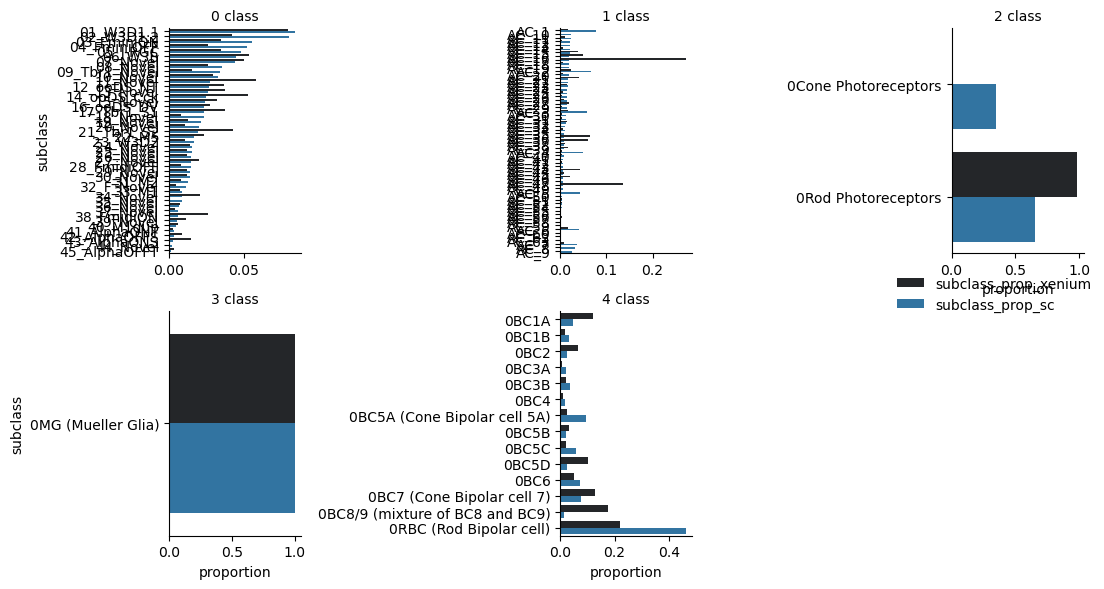

In [94]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the DataFrame for easier plotting with Seaborn
melted_df = merged_df.melt(id_vars=['subclass', 'class'], 
                           value_vars=['subclass_prop_xenium', 'subclass_prop_sc'],
                           var_name='method', value_name='proportion')

# Initialize a FacetGrid for each unique value of 'class'
g = sns.FacetGrid(melted_df, col='class', col_wrap=3, sharex=False, sharey=False)

# Create barplots
g.map_dataframe(sns.barplot, y='subclass', x='proportion', hue='method', orient='h')

# Add a legend and adjust the layout
g.add_legend()
g.set_titles(col_template="{col_name} class")
plt.tight_layout()


plt.savefig('/home/sam/scRNAseq/Xenium/E1S2R2_prediction_normalized_dist5_GCL.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


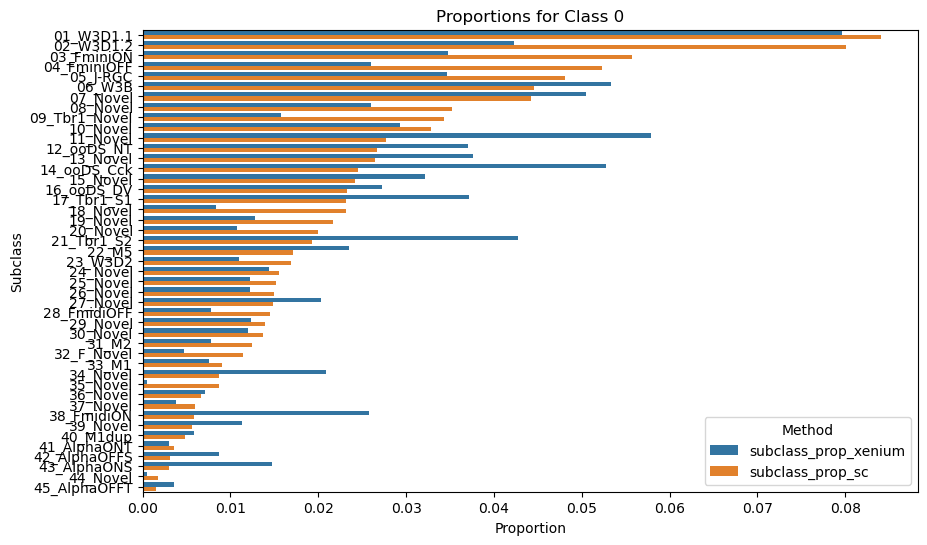

In [95]:
# Melt the DataFrame for easier plotting with Seaborn
melted_df = merged_df.melt(id_vars=['subclass', 'class'], 
                           value_vars=['subclass_prop_xenium', 'subclass_prop_sc'],
                           var_name='method', value_name='proportion')

# Filter the DataFrame for class 0
class_0_df = melted_df[melted_df['class'] == 0]

# Create a barplot for class 0
plt.figure(figsize=(10, 6)) 
sns.barplot(data=class_0_df, y='subclass', x='proportion', hue='method', orient='h')

# Add a legend and labels
plt.legend(title='Method')
plt.xlabel('Proportion')
plt.ylabel('Subclass')
plt.title('Proportions for Class 0')

# Save the plot
plt.savefig('/home/sam/scRNAseq/Xenium/E1S2R2_prediction_RGC_normalized_dist5_GCL.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()


# Code related to Gene Selection

Note the exact Notebook where these experiments were performed is largely the same as the above, albeit with many fewer utilities and only for Net style architectures

In [83]:
def compute_feature_importance(model, input_data, target_category):
    input_data.requires_grad = True # tell PyTorch to compute gradients with respect to the input
    model.zero_grad()
    output = model(input_data)
    # compute the negative log likelihood loss between the output and the target category
    loss = nn.functional.nll_loss(output, target_category) 
    # compute the gradients of the loss with respect to the input.
    loss.backward()
    # feature importance as the mean absolute value of the gradients over the batch dimension (i.e., over all input examples).
    feature_importance = input_data.grad.abs().mean(dim=0)
    return feature_importance.to('cpu')

N = 300

# Convert train_X and test_X to PyTorch tensors on the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_X = train_X.to(device)
test_X = test_X.to(device)

# Convert input data to a PyTorch tensor and move it to the GPU
input_data = torch.Tensor(test_X).to(device)

# Compute feature importance for each target category
mdl = curriculum_dict[f'Model all final genes']['model'].to(device)
for i in np.unique(y):
    curriculum_dict[f'Model all final genes'][i] = {}
    target_category = torch.full((input_data.shape[0],), i, device=device, dtype=torch.long)
    curriculum_dict[f'Model all final genes'][i]['feature importance'] = compute_feature_importance(mdl, input_data, target_category)
    top_n_values, curriculum_dict[f'Model all final genes'][i][f'top {N} features'] = torch.topk(curriculum_dict[f'Model all final genes'][i]['feature importance'], N, largest=True)
    curriculum_dict[f'Model all final genes'][i][f'top {N} genes'] = list(df.columns[curriculum_dict[f'Model all final genes'][i][f'top {N} features']])


In [84]:
ordered_gene_list = []
for i in np.unique(y):
    ordered_gene_list.append([le.inverse_transform([i]), curriculum_dict[f'Model all final genes'][i]['top 300 genes']])

In [85]:
# Pandas version
data_dict = {}
for i in np.unique(y):
    label = le.inverse_transform([i])[0]
    values = curriculum_dict[f'Model all final genes'][i]['top 300 genes']
    data_dict[label] = values

# Convert the dictionary to a pandas DataFrame
df = pd.DataFrame.from_dict(data_dict, orient='index')
df.index.name = 'Label'

In [86]:
# Step 1: Create masks for "dd_*" and "AC_*" formats
dd_mask = df.index.str.match(r'^\d{2}_.*')
ac_mask = df.index.str.match(r'^AC_.*')

# Step 2: Separate rows into three groups
dd_rows = df[dd_mask]
other_rows = df[~(dd_mask | ac_mask)]
ac_rows = df[ac_mask]

# Step 3: Concatenate the groups to create the reordered DataFrame
reordered_df = pd.concat([dd_rows, other_rows, ac_rows])


In [87]:
def unique(gene_list):
    '''This function will remove duplicates in a list while maintaing the order of first appearance'''
    seen = set()
    return [x for x in gene_list if x not in seen and not seen.add(x)]

# Initialize all_genes with the initial list of genes
all_genes = curriculum_dict[f'Model all final genes'][0]['top 300 genes']

def gene_ranker(df, all_genes, rank_ordered_genes = [], N=None, show=False):
    '''This function will take a df assuming the column order and row order respectively indicate importance of the gene or cell in question
    the list of all_genes that should ultimately be compared against must also be specified
    rank_ordered_genes is the by default empty list of genes that are being added, however, a list of genes can be provided to fix them at the top
    N is the minimum number of genes that can be returned in the rank orderered gene list
    show will print the final list if desired'''

    # Iterate through columns until rank_ordered_genes contains all_genes
    j = 0
    while set(rank_ordered_genes) != set(all_genes):
        # Get the unique genes in the next column of the input df, that is look at the genes of next importance level
        next_column = unique(list(df.iloc[:, j]))
        # Add the newly found genes to the existing gene list
        rank_ordered_genes.extend(next_column)
        # Remove duplicates while maintaing the order
        rank_ordered_genes = unique(rank_ordered_genes)
        # Iterate to the next column of genes
        j += 1
        # Check if the minimum number of genes desired has been found
        if N != None:
            if len(rank_ordered_genes) >= N:
                break
    if show:
        # Now, rank_ordered_genes contains all the unique genes from reordered_df in the order they appear
        print(rank_ordered_genes)
    return rank_ordered_genes

rank_ordered_genes = gene_ranker(reordered_df, all_genes, show=True)
print(len(rank_ordered_genes))

['Kcnip4', 'Ppp1r17', 'Syndig1l', 'Tfap2d', 'Gabrr3', 'Neurod2', 'Scgn', 'Eomes', 'Isl2', 'Isl1', 'Zic1', 'Sox9', 'Pou3f1', 'Kcnab1', 'Zeb2', 'Pcdh17', 'Spon1', 'C1ql3', 'Gabrg3', 'Tacr3', 'Vsx1', 'Grm5', 'Meis2', 'Glra1', 'Stk32a', 'Tbx20', 'Slc17a8', 'Cpne4', 'Mmp9', 'Igfbp5', 'Rprm', 'Gabrb1', 'Slc1a3', 'Pou4f3', 'Crym', 'Grm8', 'Syt2', 'Syt6', 'Lrrtm1', 'Cd24a', 'Opn4', 'Cck', 'Lypd1', 'Hes1', 'Gsg1', 'Cdh8', 'Gjd2', 'Gm4792', 'Maf', 'Rab3b', 'Pax6', 'Nfia', 'Nos1', 'Kcnb2', 'Gprc5b', 'Kcna1', 'Igfbp4', 'Fam19a1', 'Gabra4', 'Cdkn1c', 'Penk', 'Slitrk6', 'Kcnc4', 'Tmeff2', 'Foxp2', 'Calb1', 'A730046J19Rik', 'Opn1sw', 'Cd83', 'Pcdh11x', 'Tgfb2', 'Sparc', 'Lxn', 'Onecut1', 'Pantr1', 'Tnnt1', 'Gal', 'Pvalb', 'Cd9', 'Nfix', 'Lmo2', 'Kcnd2', 'Sh3bgr', 'Aif1', 'Gjc1', 'Opn1mw', 'Etv1', 'Gabra1', 'Tpbg', 'Amigo2', 'Gabra3', 'Th', 'Ccdc88b', 'Grik1', 'Serpine2', 'Slc17a7', 'Igfbp7', 'Otor', 'Kcnh1', 'Rlbp1', 'Fam19a3', 'Necab1', 'Lamp5', 'Nell1', 'Gad2', 'Kcnip1', 'Prkca', 'Evc2', 'Gngt1', '

In [88]:
rank_ordered_genes_byCell = []
for i in range(1,reordered_df.shape[0]):
    df_subset = reordered_df.iloc[:i,:]
    rank_ordered_genes_byCell = gene_ranker(df_subset, all_genes, rank_ordered_genes_byCell, N=i*3, show=True)
    print("#"*100)
print(len(rank_ordered_genes_byCell))

# Open the CSV file in write mode
csv_file_path = '/home/sam/scRNAseq/Xenium/gene_list_order_of_importance.csv'
with open(csv_file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the list as a single row in the CSV file
    writer.writerow(rank_ordered_genes_byCell)

['Kcnip4', 'Isl2', 'Gabrg3']
####################################################################################################
['Kcnip4', 'Isl2', 'Gabrg3', 'Ppp1r17', 'Isl1', 'Zic1']
####################################################################################################
['Kcnip4', 'Isl2', 'Gabrg3', 'Ppp1r17', 'Isl1', 'Zic1', 'Syndig1l', 'Grm5', 'Tfap2d']
####################################################################################################
['Kcnip4', 'Isl2', 'Gabrg3', 'Ppp1r17', 'Isl1', 'Zic1', 'Syndig1l', 'Grm5', 'Tfap2d', 'Glra1', 'Stk32a', 'Slc17a8', 'Cpne4', 'Sox9']
####################################################################################################
['Kcnip4', 'Isl2', 'Gabrg3', 'Ppp1r17', 'Isl1', 'Zic1', 'Syndig1l', 'Grm5', 'Tfap2d', 'Glra1', 'Stk32a', 'Slc17a8', 'Cpne4', 'Sox9', 'Pou3f1', 'Mmp9', 'Igfbp5']
####################################################################################################
['Kcnip4', 'Isl2', 'Gabrg3', '